# **8it - The Private Analysis Project** 

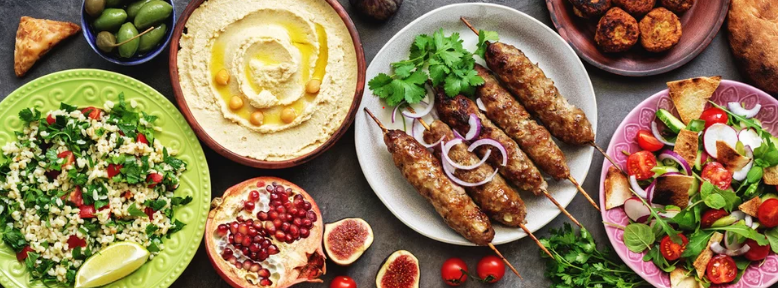

### Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px
import pypyodbc as podbc
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Question 1: Create a connection to the SQL server, 8it DB

In [2]:
# Connection to the SQL server
con_str = 'DRIVER={SQL Server};SERVER=IL-INVIVO-CAM;DATABASE=8it;Trusted_Connection=yes'
conn = podbc.connect(con_str)
print(conn)

### Question 2-4: Create a DF that wshows rach city with number of members and restaurants. Import relevant tables in DF and calculate the answer in pandas. Import the SQL query result into a DF


In [3]:
# Import the SQL query result into a DF
sql_query = '''SELECT m.ID as member_id, First_Name, Surname, Sex, Email, Monthly_Budget, City, 
                    Restaurant_Name, Restaurant_Type_ID, Restaurant_Type, Income_Persentage
                    FROM Members AS m
                    join Cities AS c 
                    on m.City_ID = c.ID
                    join Restaurants as r
                    on r.City_ID = c.ID
                    join Restaurant_Types as rt
                    on rt.ID = r.Restaurant_Type_ID
                    order by city'''
df = pd.read_sql(sql_query, conn)

# Create a DF that shows each city with the number of members and restaurants
df[['city', 'member_id', 'restaurant_name']]

city  member_id restaurant_name
0     Givatayim          8    Restaurant 8
1     Givatayim         10    Restaurant 8
2     Givatayim         13    Restaurant 8
3     Givatayim         16    Restaurant 8
4     Givatayim         19    Restaurant 8
...         ...        ...             ...
1208   Tel Aviv        178   Restaurant 30
1209   Tel Aviv        181   Restaurant 30
1210   Tel Aviv        183   Restaurant 30
1211   Tel Aviv        184   Restaurant 30
1212   Tel Aviv        193   Restaurant 30

[1213 rows x 3 columns]

### Question 5: Show the result in a scatter plot

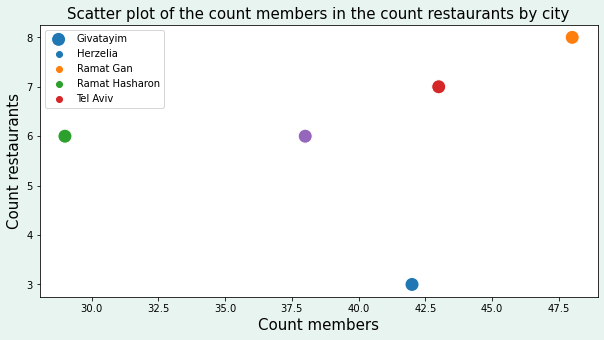

In [4]:
# Count of members in count of restaurants in each city
data_5 = (df.groupby(['city', 'restaurant_name']).count().reset_index()).groupby(['city', 'member_id']).count().restaurant_name.reset_index()

# Scatter plot
plt.figure(figsize = (10, 5), facecolor = '#e8f4f0')
ax = sns.scatterplot(x = 'member_id', y = 'restaurant_name', hue='city', s = 200, data = data_5)
plt.title('Scatter plot of the count members in the count restaurants by city', fontsize=15)
plt.legend(labels=data_5['city'], fontsize = 10)
plt.xlabel('Count members',fontsize=15)
plt.ylabel('Count restaurants',fontsize=15)
plt.show()

### Question 6: What recommendation will you give?

In [5]:
# Display the data
data_5

city  member_id  restaurant_name
0       Givatayim         42                3
1        Herzelia         48                8
2       Ramat Gan         29                6
3  Ramat Hasharon         43                7
4        Tel Aviv         38                6

### **About recommendations**

We know that the largest number of members is in Herzelia while the largest number of restaurants is in the same city.
The smallest number of restaurants is in Givataim city, and the smalles number of members is in Ramat-Gan.

We cannot draw valid conclusions and analyze the data based on a graph of two variables. We don't know the genuine reasons for this data distribution to make some recommendations to improve members and a city.

Perhaps this distribution is associated with the corresponding distribution of restaurants by city and the distribution of the location of customers, which means it fully corresponds to the demand and supply of the market.
And it can also be assumed that this is due to the pricing policy of restaurants in different cities.
We need to study the data more deeply, perhaps in some cities, there is an industrial zone with a significant concentration of customers in one place and a large volume of orders at lunchtime, maybe faster delivery of meals to the customer.
There are many factors unknown to us that affect this distribution, so we will continue to study the data.


### Question 7: Create a line chart of the time of order by hours in the day. Import the orders table from the SQL server

In [6]:
# Import Orders table from SQL server
sql_query = '''SELECT o.ID as order_id, o.Date as order_date, o.Hour as order_hour, o.Member_ID, m.City_ID as Member_City_ID,
 cc.City as Member_City, o.Restaurant_ID, r.Restaurant_Name, r.City_ID as Rest_City_ID, c.City as Restaurant_City,
Total_Order, rt.Restaurant_Type
from Orders as o
join Restaurants as r on r.ID = o.Restaurant_ID
join Restaurant_Types as rt on rt.ID = r.Restaurant_Type_ID
join Members as m on m.ID = o.Member_ID
join Cities as c on c.ID = r.City_ID
join Cities as cc on cc.ID = m.City_ID'''

orders = pd.read_sql(sql_query, conn)
orders.head()

order_id  order_date        order_hour  member_id  member_city_id  \
0         1  2020-01-01  11:00:00.0000000         25               1   
1         2  2020-01-01  11:08:00.0000000        122               4   
2         3  2020-01-01  11:10:00.0000000         62               4   
3         4  2020-01-01  11:13:00.0000000        171               5   
4         5  2020-01-01  11:13:00.0000000        152               5   

  member_city  restaurant_id restaurant_name  rest_city_id restaurant_city  \
0    Tel Aviv              6    Restaurant 6             2       Ramat Gan   
1    Herzelia              4    Restaurant 4             4        Herzelia   
2    Herzelia             16   Restaurant 16             3  Ramat Hasharon   
3   Givatayim              9    Restaurant 9             4        Herzelia   
4   Givatayim             30   Restaurant 30             1        Tel Aviv   

   total_order restaurant_type  
0          0.0       Fast Food  
1          0.0        Homemade  
2         39.0       Fast Food  
3          0.0       Fast Food  
4        153.0        Homemade

In [7]:
# Check the datatypes of 'orders'
orders.dtypes

order_id             int64
order_date          object
order_hour          object
member_id            int64
member_city_id       int64
member_city         object
restaurant_id        int64
restaurant_name     object
rest_city_id         int64
restaurant_city     object
total_order        float64
restaurant_type     object
dtype: object

The data includes **'order_date'** and **'order_hour'** as an object datatype. If we'll build the plot is based on categorical feature instead datetime it will be incorrect. let's see what it looks like.

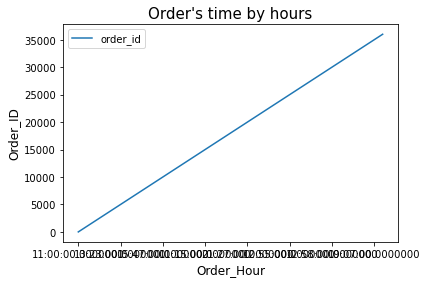

In [8]:
# Line chart of the order's time by hours with object type of the 'order_hour'
orders.plot.line(x='order_hour', y='order_id')
plt.title("Order's time by hours", fontsize=15)
plt.xlabel('Order_Hour',fontsize=12)
plt.ylabel('Order_ID',fontsize=12); 

This is the wrong plot.

So in the next question, we'll convert the date fields to the DateTime types and build the new plot.

### Question 8: Create a field in the DF with the exact hour of the order

In [9]:
# Convert the field 'hour' into dataframe 
orders['order_hour'] = pd.to_datetime(orders['order_hour'])
orders['order_date'] = pd.to_datetime(orders['order_date'])

# Create a field in the DF with the exact hour of the order
orders['order_Hour'] = orders['order_hour'].dt.hour

# Check the datatypes of 'orders'
orders.dtypes 

order_id                    int64
order_date         datetime64[ns]
order_hour         datetime64[ns]
member_id                   int64
member_city_id              int64
member_city                object
restaurant_id               int64
restaurant_name            object
rest_city_id                int64
restaurant_city            object
total_order               float64
restaurant_type            object
order_Hour                  int64
dtype: object

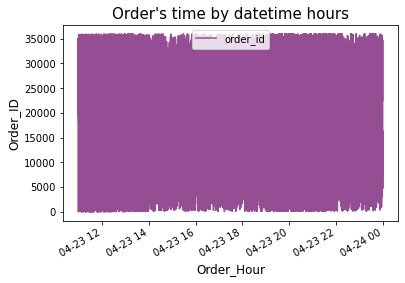

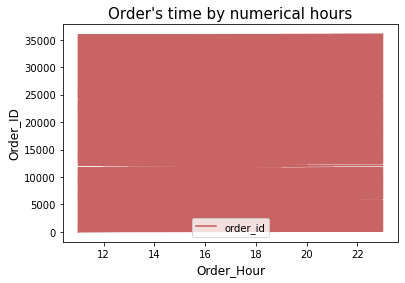

In [10]:
# Line chart of the time of order by hours (datetime type)
orders.plot.line(x='order_hour', y='order_id', color = '#954E93')
plt.title("Order's time by datetime hours", fontsize=15)
plt.xlabel('Order_Hour',fontsize=12)
plt.ylabel('Order_ID',fontsize=12)

# Line chart of the time of order by hours (numerical type)
orders.plot.line(x='order_Hour', y='order_id', color='firebrick', alpha=0.7)                
plt.title("Order's time by numerical hours", fontsize=15)
plt.xlabel('Order_Hour',fontsize=12)
plt.ylabel('Order_ID',fontsize=12)
plt.show()

### Question 9: Count the number of orders in each hour, sort the hours from earliest to latest

In [11]:
# Check the unique values of hours
orders['order_Hour'].unique()

array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [12]:
# Count the number of orders in each hour and sort the hours from earliest to latest
orders_count_per_hour = orders.groupby(['order_Hour']).agg({'order_id': ['count']}).reset_index()
orders_count_per_hour

order_Hour order_id
                 count
0          11     4898
1          12     4981
2          13     4853
3          14      933
4          15      966
5          16      909
6          17      860
7          18      934
8          19     4914
9          20     4963
10         21     4951
11         22      939
12         23      899

### Question 10: Present the result in a histogram where each hour is one bin

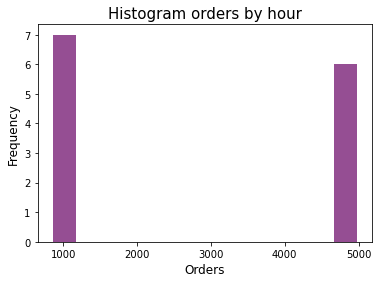

In [13]:
# Plot histogram
plt.hist(orders_count_per_hour['order_id'], bins = 13, color = '#954E93')         
plt.title('Histogram orders by hour', size = 15)
plt.xlabel('Orders', size = 12)
plt.ylabel('Frequency', size = 12)
plt.show() 

### Question 11: Why are the popular hours so popular?

For a clearer understanding of the order's time, we will build additional charts of the hour.

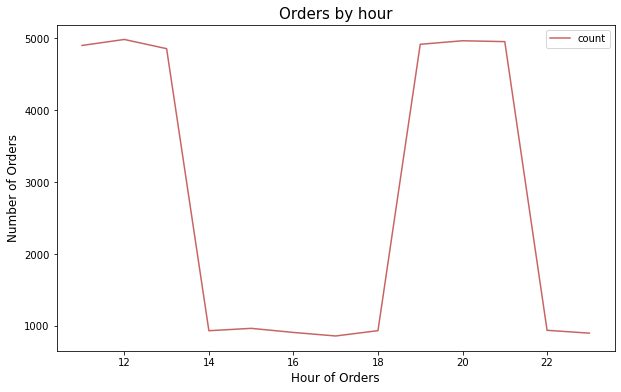

In [14]:
# Line plot
orders_count_per_hour.plot.line(x='order_Hour', y='order_id', figsize=(10,6), color='firebrick', alpha=0.7)                                
plt.title('Orders by hour', size = 15)
plt.xlabel('Hour of Orders', size = 12)
plt.ylabel('Number of Orders', size = 12);

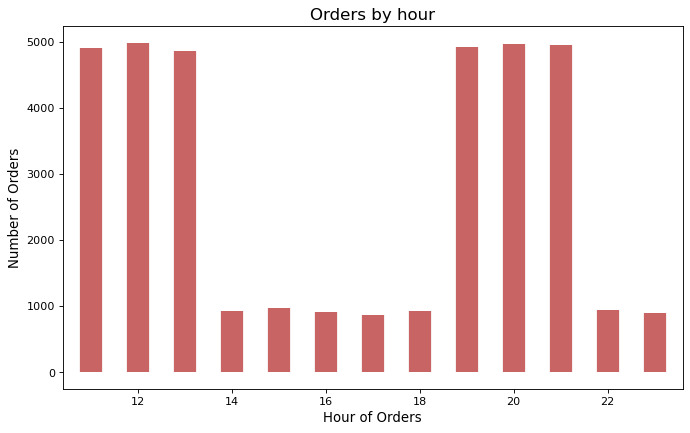

In [15]:
# Vlines plot
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', dpi= 80)
ax.vlines(x=orders_count_per_hour.order_Hour, ymin=0, ymax=orders_count_per_hour.order_id, 
          color='firebrick', alpha=0.7, linewidth=20)
plt.title('Orders by hour', size = 15)
plt.xlabel('Hour of Orders', size = 12)
plt.ylabel('Number of Orders', size = 12)
plt.show()

Now we can see the peak-time of orders.
This is a lunchtime from 11 to 14, and a dinner time from 19 to 22.

### Question 12: Create a line chart for the hours of orders by restaurants type

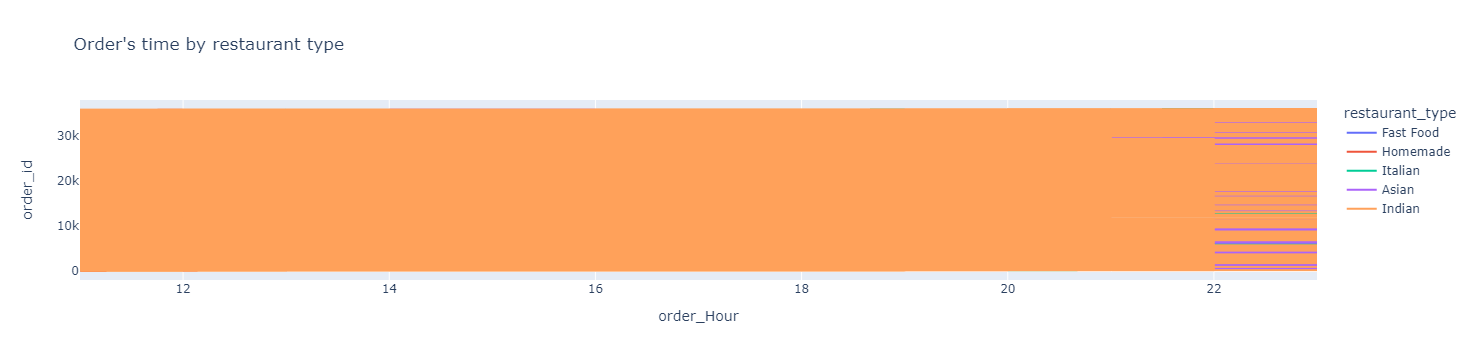

In [16]:
# Plot line chart for the hours of orders by restaurant type
fig = px.line(orders, x = 'order_Hour', y = 'order_id', color = 'restaurant_type', 
              title = "Order's time by restaurant type") 
fig.show()

We can see that in the late hours from 21:00 to 23:00 mostly Fast Food is ordered.

### Question 13: Make sure that the fields are in order for meaningful presentation

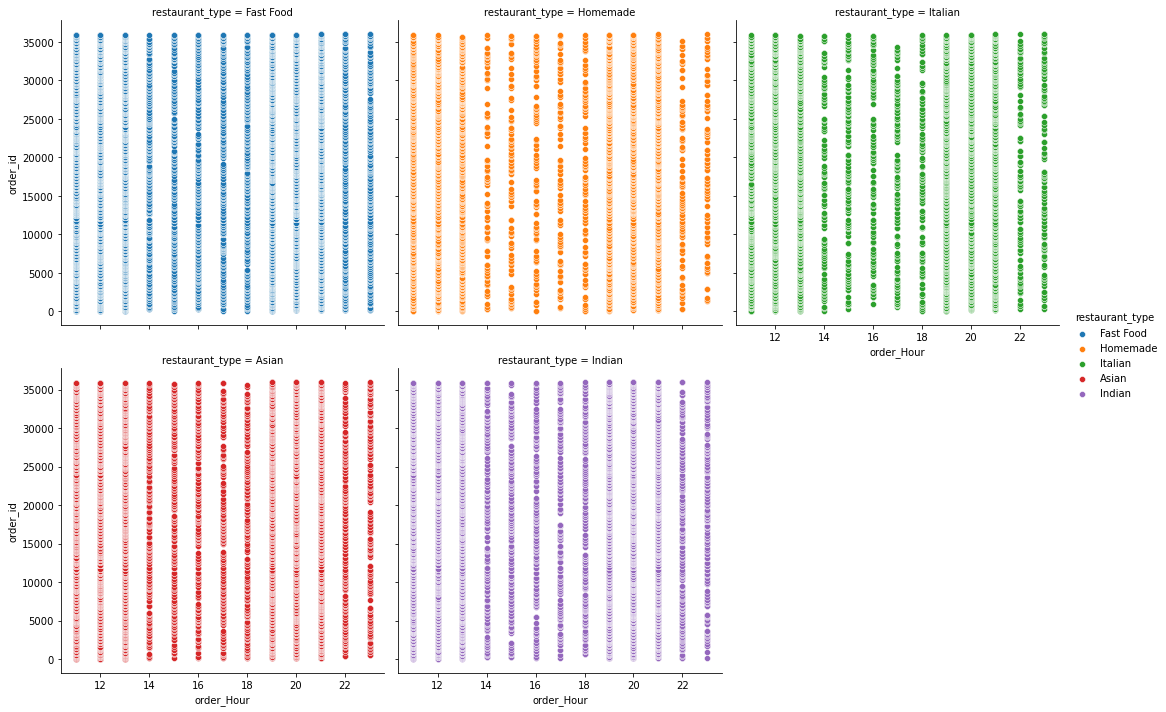

In [17]:
# Multi-plot grid 
grid = sns.FacetGrid(orders, col = 'restaurant_type', hue = "restaurant_type", 
                     col_wrap=3, size = 5, aspect = 1)
grid.map(sns.scatterplot, 'order_Hour', 'order_id')

grid.add_legend()
plt.show()

### Question 14: Show 5 pie charts - for each member city, show the number of orders from cities of restaurants. Use a FOR loop for presenting 5 charts in one "code box"

In [18]:
# Select columns and group by city
data_14_group = orders[['member_city', 'restaurant_city', 'order_id']].groupby(['member_city', 'restaurant_city']).size().reset_index()

# Create a pivot table
table_14 = pd.pivot_table(data_14_group, index=['member_city'], columns = ['restaurant_city'])
table_14

0                                           
restaurant_city Givatayim Herzelia Ramat Gan Ramat Hasharon Tel Aviv
member_city                                                         
Givatayim             759     1992      1463           1799     1543
Herzelia              831     2288      1748           2005     1772
Ramat Gan             515     1364      1047           1271     1038
Ramat Hasharon        760     2033      1529           1817     1602
Tel Aviv              715     1735      1440           1609     1325

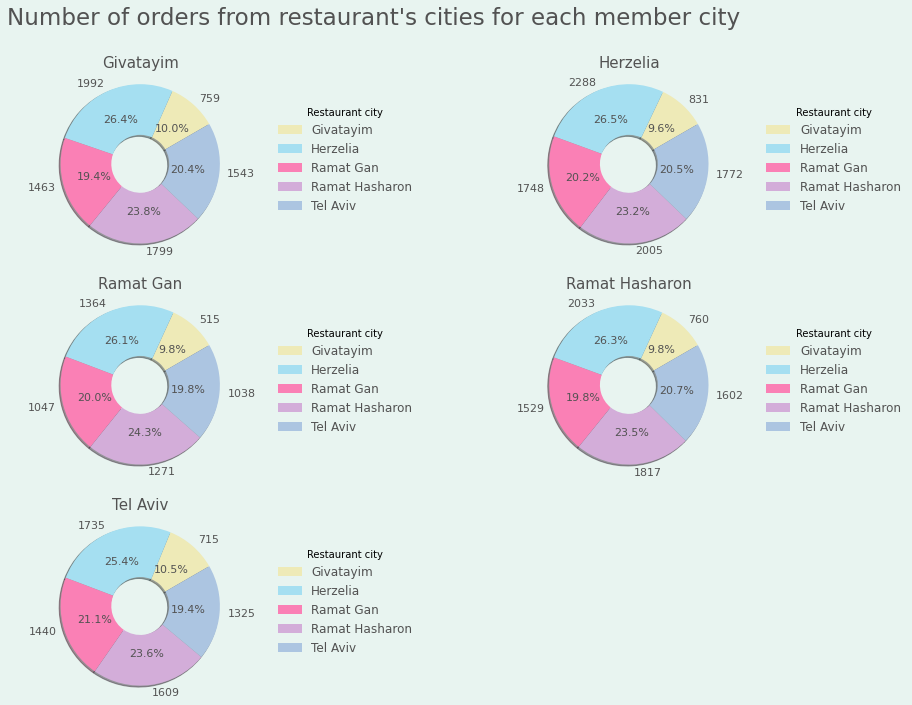

In [19]:
# Set font and color variables
font_color = '#525252'
colors = ['#eeeab7', '#a5dff1', '#fa80b5', '#d3add9', '#acc5e1']
          
# Create a figure and subplots
fig, axes = plt.subplots(3, 2, figsize = (12,30), facecolor = '#e8f4f0')
fig.delaxes(ax=axes[2,1])

for i, (idx, row) in enumerate(table_14.iterrows()):
    ax = axes[i //2, i % 2]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row,
           labels=row.values, 
           autopct = '%1.1f%%', 
           shadow = True,  
           startangle=30,
           radius=1.1,
           wedgeprops=dict(width=.7), #for donuts
           colors=colors,
           textprops={'color':font_color, 'fontsize': 11})
    ax.set_title(idx, fontsize=15, color=font_color)
    
    legend = ax.legend([x[1] for x in row.index],
                        bbox_to_anchor=(1.2, .87), #legend position
                        title = 'Restaurant city', fontsize = 'large',                       
                        loc = 'upper left',
                        frameon=False,
                        ncol = 1,
                        fancybox=True)
    for test in legend.get_texts():
        plt.setp(test, color=font_color) #legend font color
        
fig.subplots_adjust(wspace=1.7) #space between charts

title = fig.suptitle("Number of orders from restaurant's cities for each member city", 
                     y=.82, fontsize=23, color=font_color)

#To prevent the title from being cropped
plt.subplots_adjust(top=0.79, bottom=0.5)
plt.show()

### Question 15: Show 5 charts - for each restaurant city, show the number of orders from sities of members

In [20]:
# Select columns and group by city
data_15_group = orders[['restaurant_city', 'member_city', 'order_id']].groupby(['restaurant_city', 'member_city']).size().reset_index()

# Create a pivot table
table_15 = pd.pivot_table(data_15_group, index=['restaurant_city'], columns = ['member_city'])
table_15

0                                           
member_city     Givatayim Herzelia Ramat Gan Ramat Hasharon Tel Aviv
restaurant_city                                                     
Givatayim             759      831       515            760      715
Herzelia             1992     2288      1364           2033     1735
Ramat Gan            1463     1748      1047           1529     1440
Ramat Hasharon       1799     2005      1271           1817     1609
Tel Aviv             1543     1772      1038           1602     1325

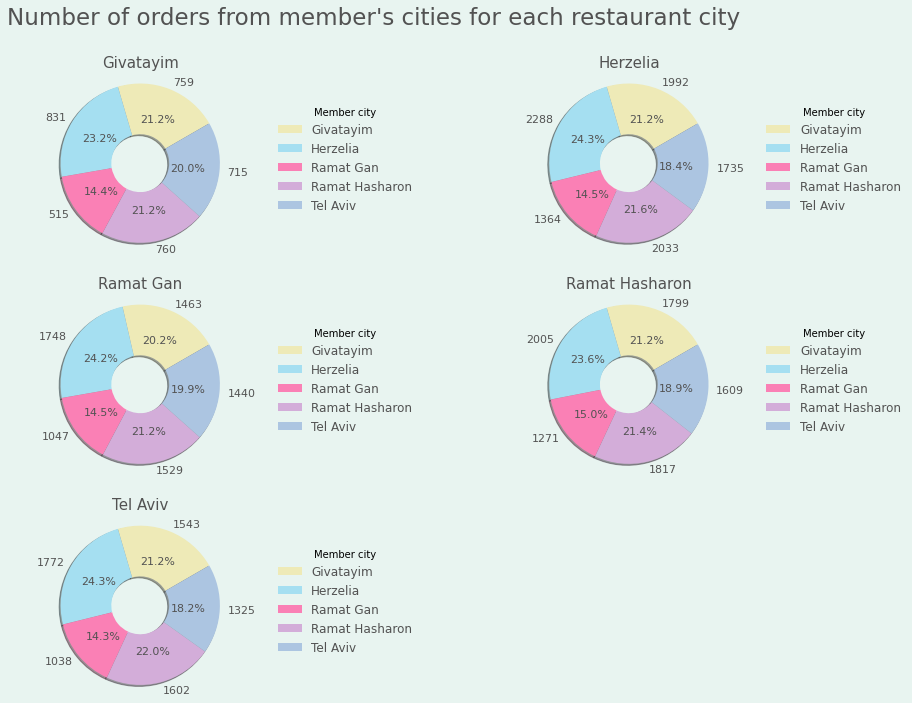

In [21]:
# Set font and color variables
font_color = '#525252'
colors = ['#eeeab7', '#a5dff1', '#fa80b5', '#d3add9', '#acc5e1']
          
# Create a figure and subplots
fig, axes = plt.subplots(3, 2, figsize = (12,30), facecolor = '#e8f4f0')
fig.delaxes(ax=axes[2,1])

for i, (idx, row) in enumerate(table_15.iterrows()):
    ax = axes[i //2, i % 2]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row,
           labels=row.values, 
           autopct = '%1.1f%%', 
           shadow = True,  
           startangle=30,
           radius=1.1,
           wedgeprops=dict(width=.7), #for donuts
           colors=colors,
           textprops={'color':font_color, 'fontsize': 11})
    ax.set_title(idx, fontsize=15, color=font_color)
    
    legend = ax.legend([x[1] for x in row.index],
                        bbox_to_anchor=(1.2, .87), #legend position
                        title = 'Member city', fontsize = 'large',                       
                        loc = 'upper left',
                        frameon=False,
                        ncol = 1,
                        fancybox=True)
    for test in legend.get_texts():
        plt.setp(test, color=font_color) #legend font color
        
fig.subplots_adjust(wspace=1.7) #space between charts

title = fig.suptitle("Number of orders from member's cities for each restaurant city", 
                     y=.82, fontsize=23, color=font_color)

#To prevent the title from being cropped
plt.subplots_adjust(top=0.79, bottom=0.5)
plt.show()

### Analysis of a single restaurant - Restaurant 15 (ONLINE)

### Question 16: Show the following detailes about Restaurant 15: name, city, restaurant type, meal type, and serve type

In [22]:
# Use one SQL query to extract the relevant data
sql_query = '''SELECT od.ID as Order_Details_ID, od.Order_ID as DB_Order_ID, od.Meal_ID as DB_Meal_ID, o.Date as Order_Date, o.Hour as Order_Hour, 
o.Member_ID, m.First_Name, m.Surname, m.Sex, m.Email, m.City_ID as Members_City_ID, cc.City as Member_City,
m.Monthly_Budget, o.Restaurant_ID, r.Restaurant_Name, o.Total_Order, r.Restaurant_Type_ID, rt.Restaurant_Type,
r.Income_Persentage as Restaurant_Income_Percentage, r.City_ID as Restaurant_City_ID, c.City as Restaurant_City,
me.ID as Meal_ID, me.Serve_Type_ID, st.Serve_Type, me.Meal_Type_ID, mt.Meal_Type, me.Hot_Cold, me.Meal_Name, me.Price
from Order_Details as od
join Orders as o on o.ID = od.Order_ID
join Restaurants as r on r.ID = o.Restaurant_ID
join Restaurant_Types as rt on rt.ID = r.Restaurant_Type_ID
join Members as m on m.ID = o.Member_ID
join Meals as me on me.ID = od.Meal_ID
join Serve_Types as st on st.ID = me.Serve_Type_ID
join Meal_Types as mt on mt.ID = me.Meal_Type_ID
join Cities as c on c.ID = r.City_ID
join Cities as cc on cc.ID = m.City_ID

where Restaurant_Name = 'Restaurant 15'
            '''
restaurant_15 = pd.read_sql(sql_query, conn)
restaurant_15[['restaurant_name', 'restaurant_city', 'restaurant_type', 'meal_type', 'serve_type']] 

restaurant_name restaurant_city restaurant_type meal_type serve_type
0      Restaurant 15        Herzelia       Fast Food     Vegan     Desert
1      Restaurant 15        Herzelia       Fast Food    Cheese     Desert
2      Restaurant 15        Herzelia       Fast Food     Vegan     Desert
3      Restaurant 15        Herzelia       Fast Food   Chicken       Main
4      Restaurant 15        Herzelia       Fast Food     Vegan    Starter
...              ...             ...             ...       ...        ...
2355   Restaurant 15        Herzelia       Fast Food     Vegan     Desert
2356   Restaurant 15        Herzelia       Fast Food   Chicken       Main
2357   Restaurant 15        Herzelia       Fast Food   Chicken       Main
2358   Restaurant 15        Herzelia       Fast Food    Cheese     Desert
2359   Restaurant 15        Herzelia       Fast Food      Beef       Main

[2360 rows x 5 columns]

### Question 17: Calculate the net income per order for the Restaurant 15

In [23]:
# Calculate 8it commission per order
restaurant_15['8it_commission_per_order'] = restaurant_15['total_order'] * restaurant_15['restaurant_income_percentage']

# Calculate restaurant net income per order
restaurant_15['restaurant_net_income_per_order'] = restaurant_15['total_order'] - restaurant_15['8it_commission_per_order']

# Create the df
data_17 = restaurant_15[['db_order_id', 'order_date', 'order_hour', 'order_details_id', 'serve_type', 'meal_type', 'meal_name', 
         'hot_cold', 'price', '8it_commission_per_order', 'restaurant_net_income_per_order']]
data_17

db_order_id  order_date        order_hour  order_details_id serve_type  \
0              29  2020-01-01  11:59:00.0000000                60     Desert   
1              29  2020-01-01  11:59:00.0000000                61     Desert   
2              49  2020-01-01  12:44:00.0000000                97     Desert   
3              78  2020-01-01  13:50:00.0000000               151       Main   
4              78  2020-01-01  13:50:00.0000000               152    Starter   
...           ...         ...               ...               ...        ...   
2355        35938  2020-07-01  19:48:00.0000000             70453     Desert   
2356        35962  2020-07-01  20:56:00.0000000             70508       Main   
2357        35962  2020-07-01  20:56:00.0000000             70509       Main   
2358        35990  2020-07-01  22:15:00.0000000             70551     Desert   
2359        35990  2020-07-01  22:15:00.0000000             70552       Main   

     meal_type meal_name hot_cold  price  8it_commission_per_order  \
0        Vegan  Meal 163      Hot  52.89                     9.225   
1       Cheese  Meal 173      Hot  39.36                     9.225   
2        Vegan  Meal 171     Cold  64.95                     6.495   
3      Chicken  Meal 172     Cold  36.70                     6.105   
4        Vegan  Meal 165      Hot  24.35                     6.105   
...        ...       ...      ...    ...                       ...   
2355     Vegan  Meal 168      Hot  34.70                    21.376   
2356   Chicken  Meal 175     Cold  59.55                    11.910   
2357   Chicken  Meal 175     Cold  59.55                    11.910   
2358    Cheese  Meal 173      Hot  39.36                     7.493   
2359      Beef  Meal 164      Hot  35.57                     7.493   

      restaurant_net_income_per_order  
0                              83.025  
1                              83.025  
2                              58.455  
3                              54.945  
4                              54.945  
...                               ...  
2355                          192.384  
2356                          107.190  
2357                          107.190  
2358                           67.437  
2359                           67.437  

[2360 rows x 11 columns]

In [24]:
# Check the data types
data_17.dtypes

db_order_id                          int64
order_date                          object
order_hour                          object
order_details_id                     int64
serve_type                          object
meal_type                           object
meal_name                           object
hot_cold                            object
price                              float64
8it_commission_per_order           float64
restaurant_net_income_per_order    float64
dtype: object

In [31]:
# Convert the fields 'order_date' and 'order_hour' to the datetime type
data_17['order_date'] = pd.to_datetime(data_17['order_date'])
data_17['order_hour'] = pd.to_datetime(data_17['order_hour'])

# Display the result whthout duplicate orders
print('       \033[1m Restaurant net income per order \n')
data_17[['db_order_id', 'restaurant_net_income_per_order']].drop_duplicates() 

        Restaurant net income per order 



db_order_id  restaurant_net_income_per_order
0              29                           83.025
2              49                           58.455
3              78                           54.945
5              90                           66.654
7              97                           89.181
...           ...                              ...
2346        35845                          141.516
2350        35933                           51.507
2351        35938                          192.384
2356        35962                          107.190
2358        35990                           67.437

[1018 rows x 2 columns]

### Question 18: Calculate the number of sales total income per meal

In [58]:
# Calculate the income per meal
data_17['meal_net_income'] = restaurant_15['restaurant_income_percentage'] * restaurant_15['price']

# Groupping by meal
data_18 = data_17.groupby(['meal_name', 'meal_net_income']).size().reset_index()

# Rename column with index [0]
data_18.rename(columns = {0:'number_of_sales'}, inplace=True)

# Calculate total income per meal
data_18['total_net_income_per_meal'] = data_18['meal_net_income'] * data_18['number_of_sales']

# Display the result
print('                \033[1m Total net income per meal \n')
data_18[['meal_name', 'number_of_sales', 'meal_net_income', 'total_net_income_per_meal']] 

                 Total net income per meal 



meal_name  number_of_sales  meal_net_income  total_net_income_per_meal
0   Meal 163              193            5.289                   1020.777
1   Meal 164              161            3.557                    572.677
2   Meal 165              188            2.435                    457.780
3   Meal 166              175            5.771                   1009.925
4   Meal 167              177            2.942                    520.734
5   Meal 168              177            3.470                    614.190
6   Meal 169              176            4.000                    704.000
7   Meal 170              188            5.723                   1075.924
8   Meal 171              187            6.495                   1214.565
9   Meal 172              179            3.670                    656.930
10  Meal 173              190            3.936                    747.840
11  Meal 174              179            3.414                    611.106
12  Meal 175              190            5.955                   1131.450

### Question 19: Show the scatter plot

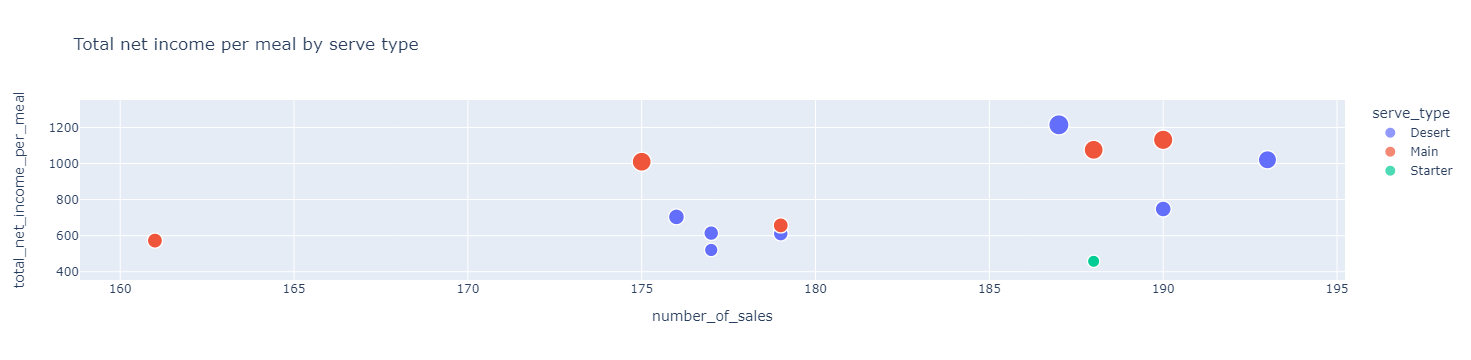

In [38]:
# Merge two dataframes from previouse questions
df = pd.merge(data_18, data_17, on=['meal_name'])

# Scatter plot
px.scatter(df, x = 'number_of_sales', y = 'total_net_income_per_meal', color = 'serve_type', size = 'price', 
           title = 'Total net income per meal by serve type')

### Question 20: Calculate the number of sales and total income per day

In [40]:
# Calculate the number of sales per day
number_of_sales_per_day = df[['order_date', 'db_order_id']].groupby('order_date').count().reset_index()

# Rename the calculated column
number_of_sales_per_day.rename(columns = {'db_order_id': 'number_of_sales'}, inplace=True)

# Show the result
print('  \033[1m Number of sales per date \n')
number_of_sales_per_day

   Number of sales per date 



order_date  number_of_sales
0   2020-01-01               12
1   2020-01-02                7
2   2020-01-03               10
3   2020-01-04                9
4   2020-01-05               23
..         ...              ...
177 2020-06-27                6
178 2020-06-28               17
179 2020-06-29               13
180 2020-06-30               21
181 2020-07-01               14

[182 rows x 2 columns]

In [59]:
# Calculate the total income per day
df['restaurant_net_income_per_day'] = df['restaurant_net_income_per_order']
total_income_per_day = df[['order_date', 'restaurant_net_income_per_day']].groupby('order_date').sum().reset_index()

# Display the result
print('       \033[1m Total net income per date \n')
total_income_per_day 

        Total net income per date 



order_date  restaurant_net_income_per_day
0   2020-01-01                        788.355
1   2020-01-02                        619.911
2   2020-01-03                        969.480
3   2020-01-04                        926.316
4   2020-01-05                       2937.105
..         ...                            ...
177 2020-06-27                        336.645
178 2020-06-28                       2076.795
179 2020-06-29                       1527.237
180 2020-06-30                       3147.777
181 2020-07-01                       1928.745

[182 rows x 2 columns]

### Question 21: Show a line chart

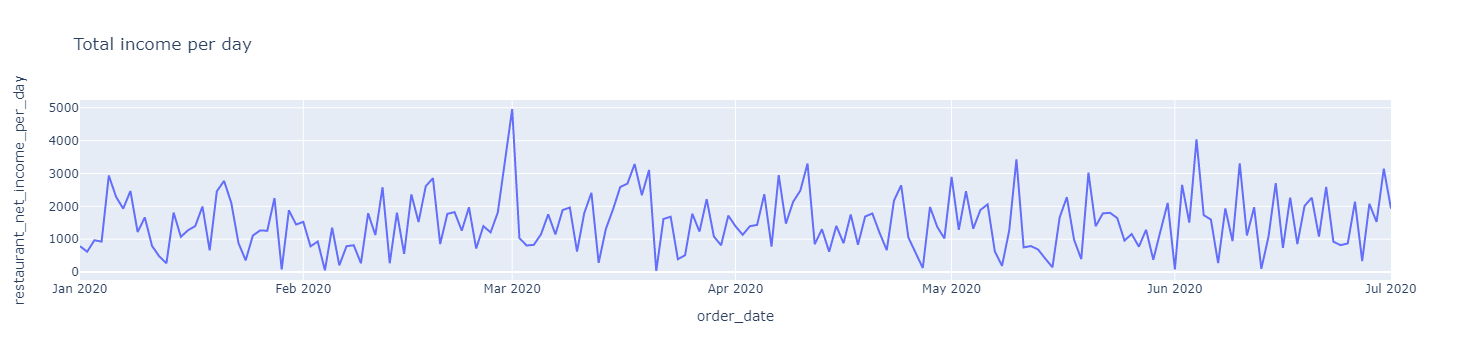

In [42]:
# Line chart
px.line(total_income_per_day, x = 'order_date', y = 'restaurant_net_income_per_day', title = 'Total income per day')

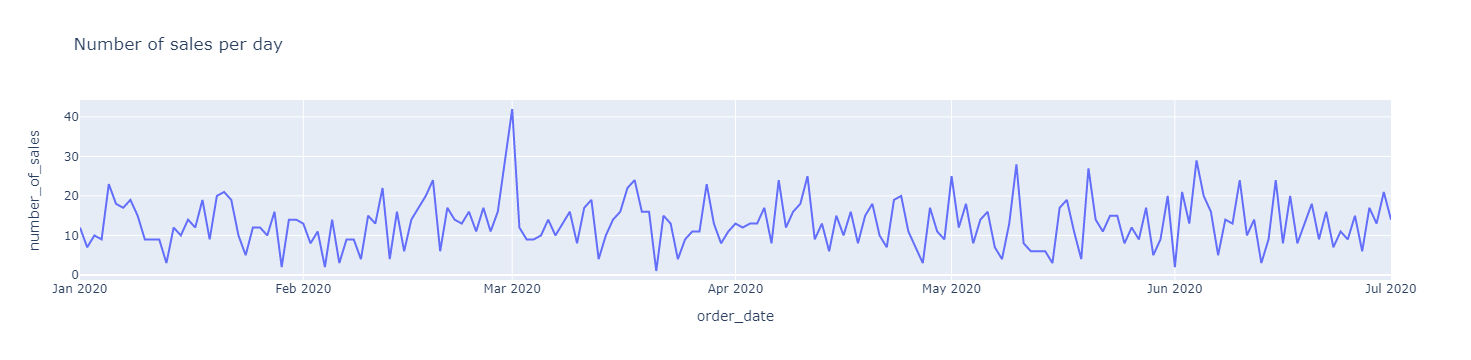

In [43]:
# Line plot
px.line(number_of_sales_per_day, x = 'order_date', y = 'number_of_sales', title = 'Number of sales per day')

What happend on 1/03/2020? Let's check in the next question.

### Question 22: What happened on 1/3/2020 that sales were so high?

In [44]:
# Choose the order_date on 1/03/2020
tab_check = df.loc[df['order_date'] == '2020-03-01']

# Sort the data by order_date
tab_check[['order_date', 'db_order_id', 'order_details_id', 'restaurant_net_income_per_order']].sort_values(by=['db_order_id'])

order_date  db_order_id  order_details_id  \
57   2020-03-01        11626             22823   
2052 2020-03-01        11626             22824   
2051 2020-03-01        11626             22822   
1133 2020-03-01        11626             22821   
1493 2020-03-01        11735             23024   
1865 2020-03-01        11745             23046   
1494 2020-03-01        11745             23045   
594  2020-03-01        11745             23044   
1677 2020-03-01        11757             23075   
2053 2020-03-01        11757             23076   
1495 2020-03-01        11757             23077   
772  2020-03-01        11794             23149   
58   2020-03-01        11794             23150   
595  2020-03-01        11794             23148   
773  2020-03-01        11812             23182   
2225 2020-03-01        11812             23183   
424  2020-03-01        11812             23185   
247  2020-03-01        11812             23181   
2054 2020-03-01        11812             23184   
1298 2020-03-01        11813             23186   
1299 2020-03-01        11829             23215   
1300 2020-03-01        11829             23216   
2226 2020-03-01        11869             23275   
248  2020-03-01        11869             23276   
1866 2020-03-01        11908             23331   
1678 2020-03-01        11924             23364   
774  2020-03-01        11924             23363   
2227 2020-03-01        11924             23365   
425  2020-03-01        11924             23366   
2228 2020-03-01        11951             23422   
59   2020-03-01        11981             23474   
1679 2020-03-01        11990             23492   
2229 2020-03-01        11990             23493   
2055 2020-03-01        11990             23494   
1301 2020-03-01        12027             23555   
2230 2020-03-01        12027             23554   
1680 2020-03-01        12044             23586   
937  2020-03-01        12087             23654   
1867 2020-03-01        12087             23655   
426  2020-03-01        12087             23656   
2231 2020-03-01        12087             23653   
60   2020-03-01        12089             23658   

      restaurant_net_income_per_order  
57                            145.053  
2052                          145.053  
2051                          145.053  
1133                          145.053  
1493                           58.455  
1865                          145.818  
1494                          145.818  
594                           145.818  
1677                          122.211  
2053                          122.211  
1495                          122.211  
772                           126.018  
58                            126.018  
595                           126.018  
773                           164.727  
2225                          164.727  
424                           164.727  
247                           164.727  
2054                          164.727  
1298                           51.507  
1299                          103.014  
1300                          103.014  
2226                           85.608  
248                            85.608  
1866                           35.424  
1678                          135.018  
774                           135.018  
2227                          135.018  
425                           135.018  
2228                           53.595  
59                             47.601  
1679                          117.351  
2229                          117.351  
2055                          117.351  
1301                          105.102  
2230                          105.102  
1680                           33.030  
937                           142.164  
1867                          142.164  
426                           142.164  
2231                          142.164  
60                             47.601

We can see that the data includes duplicates order_id, because one order has the few meals and the each row of the order has unique number under 'order_detail_id'. We'll don't clean the our data from column 'order_detail_id' because it proportionally covers the whole period of our dataset. We can conclude that there were really more sales on this day than on other days.

### Question 23: Analysis for external data source for Restaurant 15 (OFFLINE) in excel including 3 sheets: 'Meals', 'Invoices', 'Orders'

### Question 24: Import excel data

In [45]:
# Load the excel file
meals = pd.read_excel('Invoices Big Grill Restaurant - Not Online Extract 20200701.xlsx', sheet_name='Meals')
invoices = pd.read_excel('Invoices Big Grill Restaurant - Not Online Extract 20200701.xlsx', sheet_name='Invoices')
orders = pd.read_excel('Invoices Big Grill Restaurant - Not Online Extract 20200701.xlsx', sheet_name='Orders')

# Merge three sheets of the excel data
tab1 = orders[['order_id', 'invoice_id', 'meal_id']].merge(invoices[['invoice_id', 'invoice_number']], 
                                                           on = 'invoice_id', how = 'left').merge(meals[['meal_id', 'meal_name', 'meal_size', 
                                                                                 'price', 'meal_type']], 
                                                           on = 'meal_id', how = 'left')
tab1.head()

order_id  invoice_id  meal_id invoice_number      meal_name meal_size  \
0         1           1        8   00001-000001      Hamburger     Large   
1         2           1        9   00001-000001    Fresh Fruit    Normal   
2         3           1        1   00001-000001  Apple Crumble     Large   
3         4           2        4   00001-000002  Beyond Burger    Normal   
4         5           2        5   00001-000002    Cheese Cake     Small   

   price meal_type  
0  57.23      Beef  
1  64.95     Vegan  
2  52.89     Vegan  
3  57.71     Vegan  
4  29.42    Cheese

### Question 25: Generate a new meals df with all details from the DB and new file

In [46]:
# Generate a new meals df with all the details from the DB and new file
table_25 = tab1.merge(restaurant_15, on = ['meal_name', 'price', 'meal_type'], how = 'left')
table_25[['db_meal_id', 'meal_id_x', 'meal_name', 'meal_size', 'hot_cold', 'meal_type', 'serve_type', 'price']]                      

db_meal_id  meal_id_x         meal_name meal_size hot_cold meal_type  \
0            NaN          8         Hamburger     Large      NaN      Beef   
1            NaN          9       Fresh Fruit    Normal      NaN     Vegan   
2            NaN          1     Apple Crumble     Large      NaN     Vegan   
3            NaN          4     Beyond Burger    Normal      NaN     Vegan   
4            NaN          5       Cheese Cake     Small      NaN    Cheese   
...          ...        ...               ...       ...      ...       ...   
5596         NaN         12         Ice Cream    Normal      NaN    Cheese   
5597         NaN         13  Chicken Sandwich     Large      NaN   Chicken   
5598         NaN          9       Fresh Fruit    Normal      NaN     Vegan   
5599         NaN          4     Beyond Burger    Normal      NaN     Vegan   
5600         NaN         12         Ice Cream    Normal      NaN    Cheese   

     serve_type  price  
0           NaN  57.23  
1           NaN  64.95  
2           NaN  52.89  
3           NaN  57.71  
4           NaN  29.42  
...         ...    ...  
5596        NaN  34.14  
5597        NaN  59.55  
5598        NaN  64.95  
5599        NaN  57.71  
5600        NaN  34.14  

[5601 rows x 8 columns]

### Question 26: Generate a df and with monthly income based on invoice number, orders and meal prices

In [47]:
# Create a relevant dataframe
a = table_25[['invoice_number', 'order_id', 'price']]

# Extract the first 5 digits that represent the month in column 'invoice_number', and save it in the new column 'business_month'
a['business_month'] = [x[:5] for x in a['invoice_number']]
a.head() 

invoice_number  order_id  price business_month
0   00001-000001         1  57.23          00001
1   00001-000001         2  64.95          00001
2   00001-000001         3  52.89          00001
3   00001-000002         4  57.71          00001
4   00001-000002         5  29.42          00001

Why not extract the 4th and 5th digits that represent the month in columns 'invoice_number'? Let's try it.

In [48]:
# Extract the 2 digits that represent the month in columns 'invoice_number' and save it in the new column 'business_month'
a['business_month'] = [x[3:5] for x in a['invoice_number']]
a.head()

invoice_number  order_id  price business_month
0   00001-000001         1  57.23             01
1   00001-000001         2  64.95             01
2   00001-000001         3  52.89             01
3   00001-000002         4  57.71             01
4   00001-000002         5  29.42             01

The data includes the period for 14 months from May 2019. 
We're interesting on 2020 year, so we'll delete don't relevant invoices.
That is first 8 business months.  
Let's find the index in the data where the ninth business month starts and select the data that began.

In [49]:
#Find the start index with 09 month
a.loc[a['business_month'] == '09'].head()

invoice_number  order_id  price business_month
3219   00009-000001      3220  57.23             09
3220   00009-000001      3221  36.70             09
3221   00009-000002      3222  57.71             09
3222   00009-000002      3223  52.89             09
3223   00009-000002      3224  36.70             09

We'll choose the data with invoices in 2020 year only. That means from 9 to 14 months.

In [50]:
# Choose the data from 09 to 14 business_month
b = a.iloc[3219:]

# Rename the values of the column 'business_month' to the datetime match format
b.loc[a['business_month'] == '09', 'business_month'] = '2020-01-31'
b.loc[a['business_month'] == '10', 'business_month'] = '2020-02-28'
b.loc[a['business_month'] == '11', 'business_month'] = '2020-03-31'
b.loc[a['business_month'] == '12', 'business_month'] = '2020-04-30'
b.loc[a['business_month'] == '13', 'business_month'] = '2020-05-31'
b.loc[a['business_month'] == '14', 'business_month'] = '2020-06-30'

# Convert the field 'business_month' to the datetime type
b['business_month'] = pd.to_datetime(b['business_month'])

# Check the datatypes
b.head()

invoice_number  order_id  price business_month
3219   00009-000001      3220  57.23     2020-01-31
3220   00009-000001      3221  36.70     2020-01-31
3221   00009-000002      3222  57.71     2020-01-31
3222   00009-000002      3223  52.89     2020-01-31
3223   00009-000002      3224  36.70     2020-01-31

In [51]:
# Calculate the monthly income for offline restaurant 'Big Grill'
monthly_income_offline = b[['business_month', 'invoice_number', 'price']].groupby(['business_month']).sum().reset_index()
monthly_income_offline['month'] = monthly_income_offline['business_month'].dt.month

# Rename the calculated column
monthly_income_offline.rename(columns = {'price': 'offline'}, inplace=True)

# Display the result
print('\033[1m Monthly offline income \n')
monthly_income_offline[['month', 'offline']]

 Monthly offline income 



month   offline
0      1  18132.47
1      2  16674.85
2      3  19574.51
3      4  16191.33
4      5  14301.12
5      6  19443.87

### Question 27: Generate a df and with NET monthly income from the DB - only for Restaurant 15

In [52]:
# Choose the relevant data
data_27 = data_17[['db_order_id', 'restaurant_net_income_per_order']].drop_duplicates()

# Create a field in the DF with the exact month of the order
data_27['month'] = data_17['order_date'].dt.month

# Calculate the monthly income for offline restaurant 'Big Grill'
monthly_income_online = data_27[['month', 'restaurant_net_income_per_order']].groupby(['month']).sum().reset_index()

# Rename the calculated column
monthly_income_online.rename(columns = {'restaurant_net_income_per_order': 'online'}, inplace=True) 

# Remove the 7-th month
monthly_income_online = monthly_income_online[:-1]

# Show the result
print('\033[1m Monthly online net income \n')
monthly_income_online[['month', 'online']]

 Monthly online net income 



month     online
0      1  15007.644
1      2  13592.691
2      3  16891.488
3      4  15521.904
4      5  15181.236
5      6  16286.085

### Question 28: Generate a line chart with Restaurant 15 income from online and offline monthly incomes (2 lines - one for offline and one for online)

In [55]:
# Merge to df
data_28 = monthly_income_online.merge(monthly_income_offline, on = ['month'], how = 'left')

# Display the result
print('\033[1m Monthly net income \n')
data_28[['month', 'online', 'offline']]

 Monthly net income 



month     online   offline
0      1  15007.644  18132.47
1      2  13592.691  16674.85
2      3  16891.488  19574.51
3      4  15521.904  16191.33
4      5  15181.236  14301.12
5      6  16286.085  19443.87

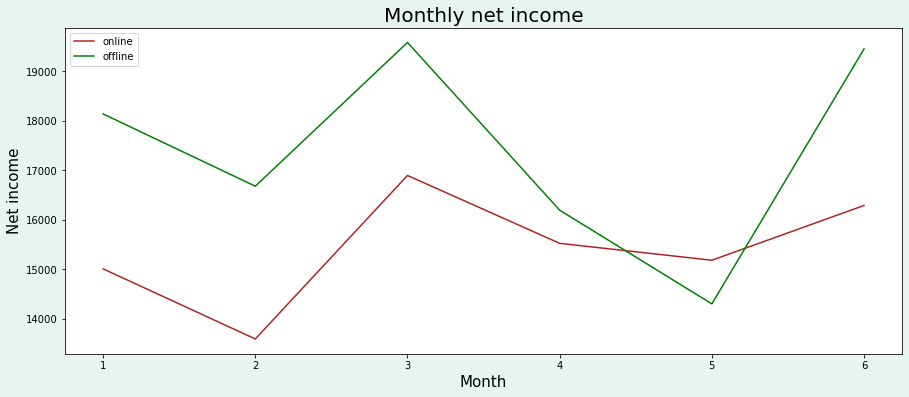

In [56]:
# Line plot
plt.figure(figsize=(15,6), facecolor = '#e8f4f0')
plt.plot('month', 'online', data = data_28, color='firebrick')
plt.plot('month', 'offline', data = data_28, color = 'g')
plt.title('Monthly net income', size = 20)
plt.xlabel('Month', size = 15)
plt.ylabel('Net income', size = 15)
plt.legend()
plt.show()

To compare the online business model's effectiveness and efficiency, consider the online income dynamics concerning the offline business model on the graph.

We will take the income from the offline business model as a base and look at the income trend from the online model in the percentage.

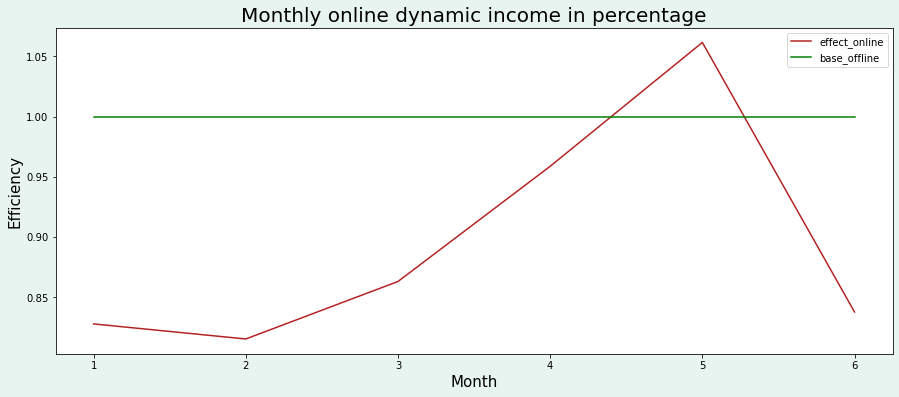

In [57]:
# Calculate the data in percentage
data_28['effect_online'] = data_28['online'] / data_28['offline']
data_28['base_offline'] = data_28['offline'] / data_28['offline']
data_28[['month', 'base_offline', 'effect_online']]

# Line plot
plt.figure(figsize=(15,6), facecolor = '#e8f4f0')
plt.plot('month', 'effect_online', data = data_28, color='firebrick')
plt.plot('month', 'base_offline', data = data_28, color = 'g')
plt.title('Monthly online dynamic income in percentage', size = 20)
plt.xlabel('Month', size = 15)
plt.ylabel('Efficiency', size = 15)
plt.legend()
plt.show()

### Conclusion

Looking at the chart above, we can observe a seasonal decline in orders during the winter and an increase from February to March.
During this period, the income from the online business is approximately 15 percent lower than the offline business. In March, the incomes of both businesses fall, but the difference between them is reduced and is equal to zero in mid-April.
The income picture was changed during the next month due to COVID-19 dining restrictions. You can see how the online business model takes over from the traditional business in the restaurant industry.
After the easing of restrictions, the situation is recovering and moving towards a gap of about 15 percent, as it was at the beginning of the year. 
The total period for the first half of 2020 shows us a difference in incomes of about 11 percent in favor of the offline business.

The advent of appealing, user-friendly apps and tech-enabled driver networks, coupled with changing consumer expectations, has unlocked ready-to-eat food delivery as a significant category. Lockdowns and physical-distancing requirements early on in the pandemic gave the type an enormous boost, with delivery becoming a lifeline for the hurting restaurant industry. Moving forward, it is poised to remain a permanent fixture in the dining landscape.

Over time, people's habits change, Internet service platforms become simpler, assortment expands, service time decreases, competition increases, and undoubtedly the digital form of the business model is successful in the long term. And at the moment, the online-branch is an additional income for the restaurant, an additional marketing way to attract customers, and a source of increasing sales, so the restaurant needs to reduce the costs of this model.